<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to predict the future 24 hours of energy demand. This is a multivariate time series forecasting project.

##  1. Data Preprocessing


In [1]:
## Set up

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Dropout

df = pd.read_csv('energy_dataset.csv', usecols=['time','total load actual', 'price actual'])
print(f'The shape of the dataset is {df.shape}\n')
print(df.info())


The shape of the dataset is (35064, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
 2   price actual       35064 non-null  float64
dtypes: float64(2), object(1)
memory usage: 821.9+ KB
None


In [2]:
## Managing Time Column

# Convert to datetime
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Ensure time series is in ascending order
df.sort_index(inplace=True)

#Calculate time differences
time_diffs = df.index.to_series().diff()
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]             #Identify any irregularities, apart from the first row
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


In [3]:
## Handling Missing Values

non_numeric_values = ['?', 'N/A', '-', ''] # List of non-numeric values to replace

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')
# Check out null value situation
df.isna().sum()

,0
total load actual,36
price actual,0


In [4]:
# List of non-numeric values to replace
non_numeric_values = ['?', 'N/A', '-', '']

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')
# Check out null value situation
df.isna().sum()

,0
total load actual,36
price actual,0


In [5]:
df[df.isna().any(axis=1)]

,total load actual,price actual
time,,
2015-01-05 11:00:00,NaN,79.14
2015-01-05 12:00:00,NaN,73.95
2015-01-05 13:00:00,NaN,71.93
2015-01-05 14:00:00,NaN,71.50
2015-01-05 15:00:00,NaN,71.85
2015-01-05 16:00:00,NaN,80.53
2015-01-28 12:00:00,NaN,77.62
2015-02-01 06:00:00,NaN,16.98
2015-02-01 07:00:00,NaN,19.56


In [6]:
# We only use the recent two years' data for training
df = df[df.index >= '2017-01-01 00:00:00'].copy()

# Impute the missing values with interpolation
df['total load actual'] = df['total load actual'].interpolate(method='linear')

df.isna().sum()

,0
total load actual,0
price actual,0


In [7]:
## Formating Data Type
df.info() # For current data, all good, as shown below


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17519 entries, 2017-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  17519 non-null  float64
 1   price actual       17519 non-null  float64
dtypes: float64(2)
memory usage: 410.6 KB


All date types are good, no need to convert here.

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual,17519.0,28961.884154,4593.851657,18179.00,25042.50,29123.00,32534.5,41015.0
price actual,17519.0,61.382997,12.410521,10.66,54.01,60.67,69.6,116.8


They are in different scale, we need to scale them.

In [9]:
## Feature Seclection
used_cols = ['total load actual', 'price actual'] #Since there are only two features, both of them are useful, no need to select features.

## Smooth features
rolling_size = 3
for col in used_cols:
    df[f'{col}_roll'] = df[col].rolling(window=rolling_size).mean()
df.dropna(inplace=True)
# We use the rolling values instead of original values as input variables
roll_cols = ['total load actual_roll', 'price actual_roll']


## Train Test Split
split_step = int(df.shape[0]*0.8)
train = df.iloc[:split_step].copy()
ver = df.iloc[split_step:].copy()
valid = ver.iloc[:int(ver.shape[0]*0.5)].copy()
test = ver.iloc[int(ver.shape[0]*0.5):].copy()

## Scaling

# Initialize the scalers
input_scaler = MinMaxScaler()
load_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

# Avoid SettingWithCopyWarning by assigning results directly back to the DataFrame
for col in roll_cols:
    train.loc[:,f'{col}_scaled'] = input_scaler.fit_transform(train[[col]].copy())
    valid.loc[:,f'{col}_scaled'] = input_scaler.transform(valid[[col]].copy())
    test.loc[:,f'{col}_scaled'] = input_scaler.transform(test[[col]].copy())

train.loc[:,'total load actual scaled'] = load_scaler.fit_transform(train[['total load actual']].copy())
train.loc[:,'price actual scaled'] = price_scaler.fit_transform(train[['price actual']].copy())
valid.loc[:,'total load actual scaled'] = load_scaler.transform(valid[['total load actual']].copy())
valid.loc[:,'price actual scaled'] = price_scaler.transform(valid[['price actual']].copy())
test.loc[:,'total load actual scaled'] = load_scaler.transform(test[['total load actual']].copy())
test.loc[:,'price actual scaled'] = price_scaler.transform(test[['price actual']].copy())



train.drop(['total load actual_roll', 'price actual_roll'], axis=1, inplace=True)
valid.drop(['total load actual_roll', 'price actual_roll'], axis=1, inplace=True)
test.drop(['total load actual_roll', 'price actual_roll'], axis=1, inplace=True)

# Final, we get the datasets ready for michine learning
train_s = train.drop(['total load actual', 'price actual'], axis=1)
valid_s = valid.drop(['total load actual', 'price actual'], axis=1)
test_s = test.drop(['total load actual', 'price actual'], axis=1)


## 2. EDA

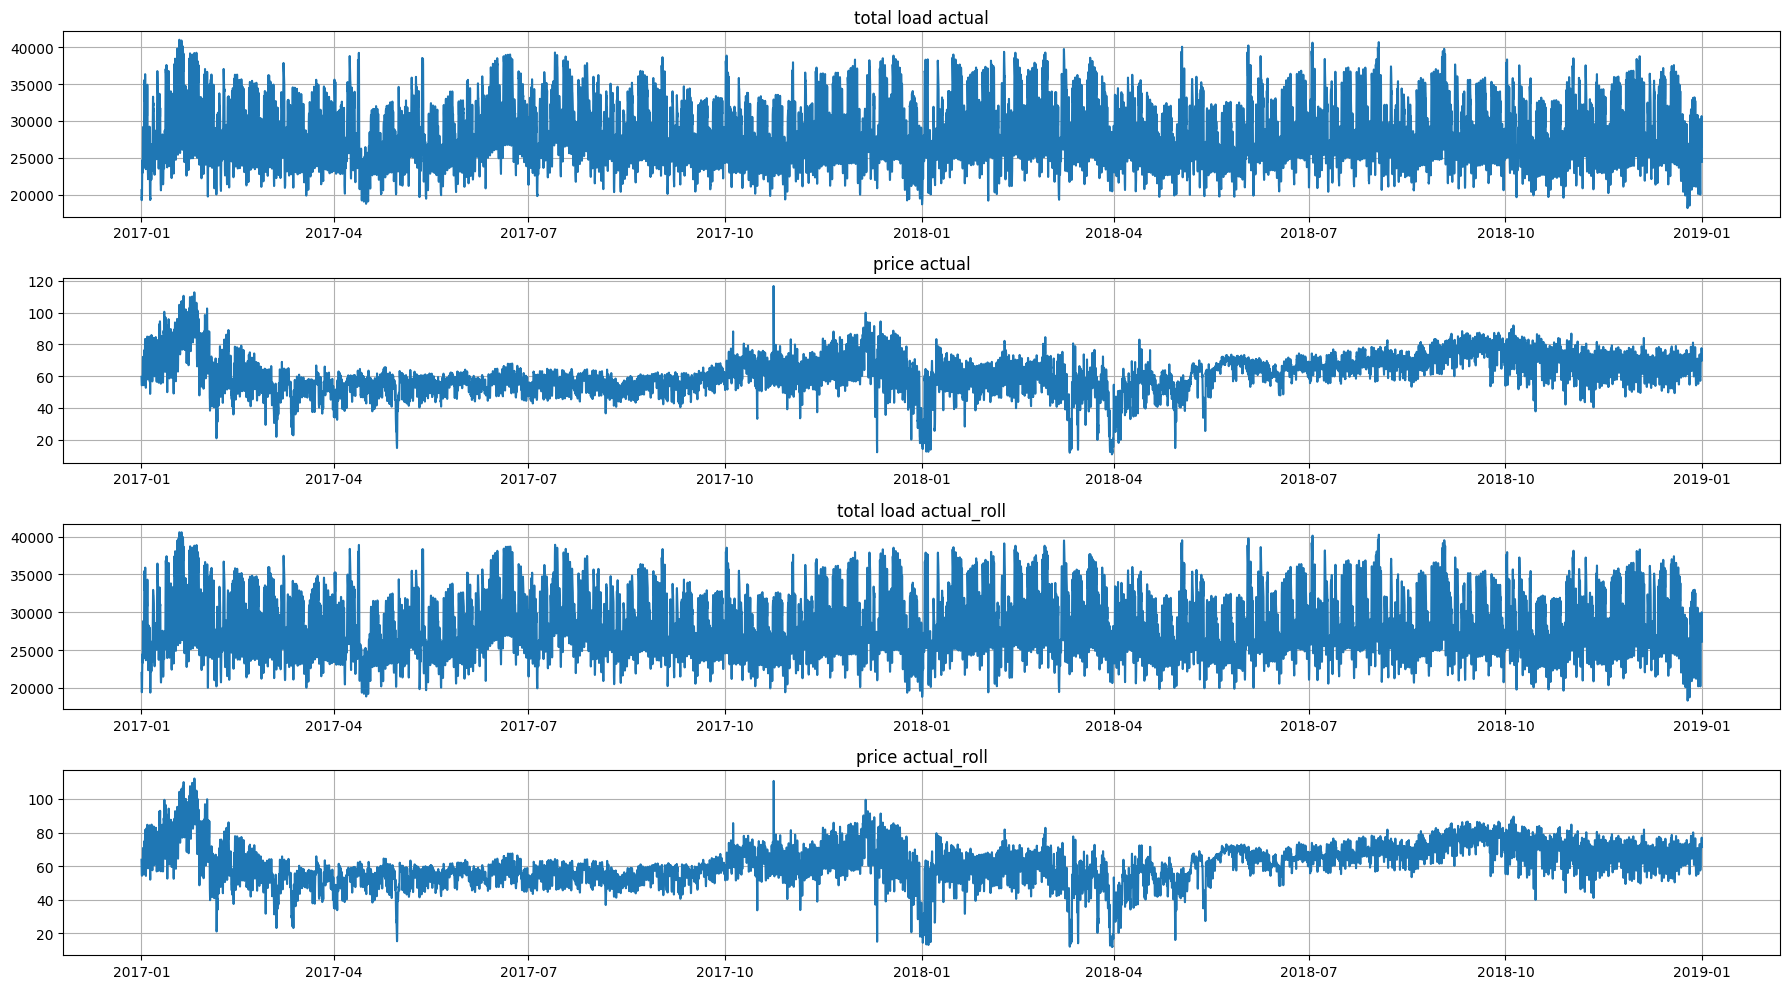

In [10]:
##Visualizing Data

fig, axs = plt.subplots(len(df.columns), 1, figsize=(18, 10)) # Changed the first argument to len(df.columns)

for i, col in enumerate(df.columns):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

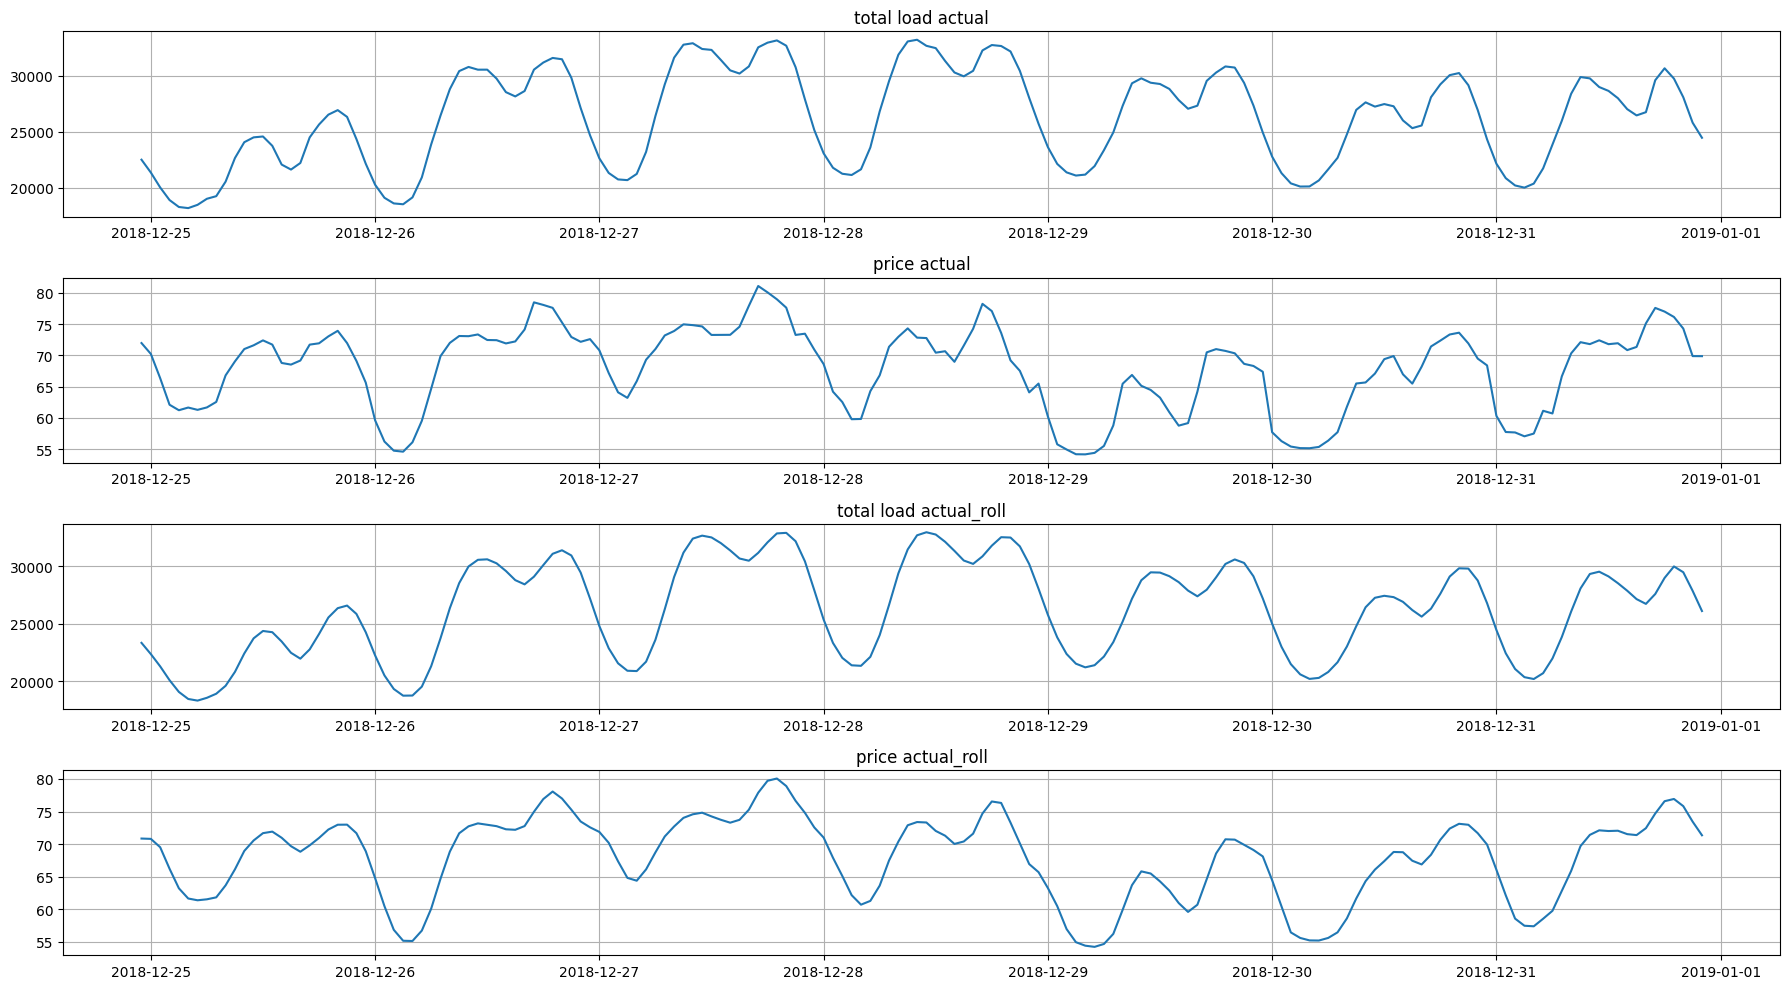

In [11]:
# Visualize a few data at the end
fig, axs = plt.subplots(len(df.columns), 1, figsize=(18, 10))

for i, col in enumerate(df.columns):
    axs[i].plot(df[col][-24*7:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Statistics

train_s.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual_roll_scaled,14013.0,0.466992,0.204911,0.0,0.295947,0.471650,0.619915,1.0
price actual_roll_scaled,14013.0,0.471560,0.119193,0.0,0.404717,0.466800,0.540176,1.0
total load actual scaled,14013.0,0.460790,0.205780,0.0,0.285887,0.467685,0.616384,1.0
price actual scaled,14013.0,0.457113,0.115307,0.0,0.391558,0.452233,0.524025,1.0


In [14]:
# autocorrelation

train_s.corr()

,total load actual_roll_scaled,price actual_roll_scaled,total load actual scaled,price actual scaled
total load actual_roll_scaled,1.000000,0.471802,0.957589,0.448421
price actual_roll_scaled,0.471802,1.000000,0.455171,0.968132
total load actual scaled,0.957589,0.455171,1.000000,0.480423
price actual scaled,0.448421,0.968132,0.480423,1.000000


## 3. Feature Engineering



```
window_size = 3

dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

for window in dataset.take(1):
  print(window.numpy())
  print(f'shape: {window.numpy().shape}')

[[  0.482  247.138    0.       0.       0.       0.484 ]
 [  0.4824 247.212    0.       0.       0.       0.484 ]
 [  0.4824 247.364    0.       0.       0.       0.482 ]
 [  0.4828 247.564    0.       0.       0.       0.482 ]]
shape: (4, 6)

for window in dataset.take(1):
  print(window[:-1,:-1], window[-1][-1])

tf.Tensor(
[[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]], shape=(3, 5), dtype=float64) tf.Tensor(0.482, shape=(), dtype=float64)

# group into features and lables
dataset = dataset.map(lambda window: (window[:-1,:-1], window[-1][-1]))

for x, y in dataset.take(2):
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  print()

x =  [[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]]
y =  0.482

x =  [[  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]
 [  0.4828 247.564    0.       0.       0.    ]]
y =  0.482
```



### Single Step

In [15]:
def single_step_windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, input_columns, output_columns, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size (int) - buffer size to use for the shuffle method
      input_columns (list of str, or ints) - the names or indices of the columns to be used as features
      output_columns (str, or ints) - the names or indices of the columns to be used as labels
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing Xs and ys.
    """

    # If column names are provided, map feature_columns and label_columns from names to indices
    if column_names is not None:
        input_columns = [column_names.index(col) if isinstance(col, str) else col for col in input_columns]
        output_columns = [column_names.index(col) if isinstance(col, str) else col for col in output_columns]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], input_columns, axis=-1),
                                          tf.gather(window[-1], output_columns, axis=-1))) # -1 refers to single step method, we only forecast the next time step

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [42]:
# Build CNN-LSTM-DNN Model
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        #tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-1 * 10**(-epoch / 3))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=12, callbacks=[lr_schedule])

    return history


def create_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=200,
        decay_rate=0.8,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model


def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the input variables
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

#### Single Step Single Output


In [51]:
# Price

column_names = train_s.columns.to_list()
input_cols = ['total load actual_roll_scaled', 'price actual_roll_scaled']
output_cols = ['price actual scaled']
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*30 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

In [43]:
train_price_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

lr_history = adjust_learning_rate(train_price_set)

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - loss: 0.0111 - mae: 0.0950 - learning_rate: 0.1000
Epoch 2/12


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 0.0027 - mae: 0.0556 - learning_rate: 0.0464
Epoch 3/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.0024 - mae: 0.0521 - learning_rate: 0.0215
Epoch 4/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - loss: 0.0023 - mae: 0.0507 - learning_rate: 0.0100
Epoch 5/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0023 - mae: 0.0500 - learning_rate: 0.0046
Epoch 6/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0022 - mae: 0.0500 - learning_rate: 0.0022
Epoch 7/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 0.0022 - mae: 0.0498 - learning_rate: 0.0010
Epoch 8/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0022 - mae: 0.0504 - learning_rate: 4.6416e-04
Epoch 9/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.0022 - mae: 0.0503 - learning_rate: 2.1544e-04
Epoch 10/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0022 - mae: 0.0502 - learning_rate: 1.0000e-04
Epoch 11/12
437/437 ━━━━━━━━━━━━━━━

(1e-05, 1.0, 0.0, 0.005)

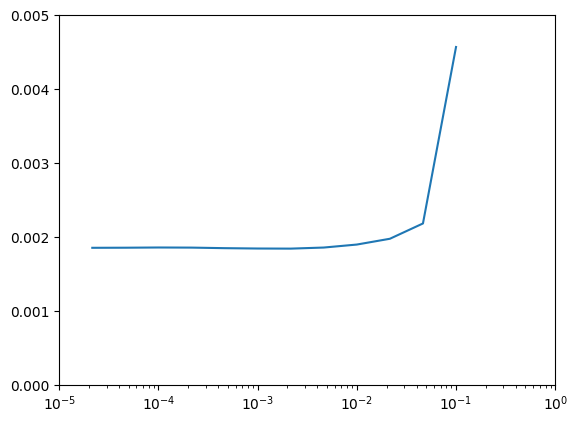

In [46]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-5, 1, 0, 0.005])

In [52]:
single_step_single_output_price_model = create_model(initial_lr=3e-1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

validation_price_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

history = single_step_single_output_price_model.fit(train_price_set, validation_data=validation_price_set, epochs=40, callbacks=[early_stopping])


Epoch 1/40
    437/Unknown 22s 42ms/step - loss: 0.0127 - mae: 0.0988

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - loss: 0.0127 - mae: 0.0987 - val_loss: 0.0019 - val_mae: 0.0497
Epoch 2/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0027 - mae: 0.0549 - val_loss: 0.0014 - val_mae: 0.0407
Epoch 3/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0020 - mae: 0.0475 - val_loss: 0.0012 - val_mae: 0.0361
Epoch 4/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0018 - mae: 0.0442 - val_loss: 0.0010 - val_mae: 0.0338
Epoch 5/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0016 - mae: 0.0414 - val_loss: 0.0010 - val_mae: 0.0333
Epoch 6/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0015 - mae: 0.0401 - val_loss: 9.7252e-04 - val_mae: 0.0325
Epoch 7/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0014 - mae: 0.0394 - val_loss: 9.5992e-04 - val_mae: 0.0323
Epoch 8/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0014 - mae: 0.0389 - val_loss: 9.8931e-04 - val_mae: 0.0328
Epoch 9/40
437/437 ━━━━━━━━━━━━━━━━━━━━

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


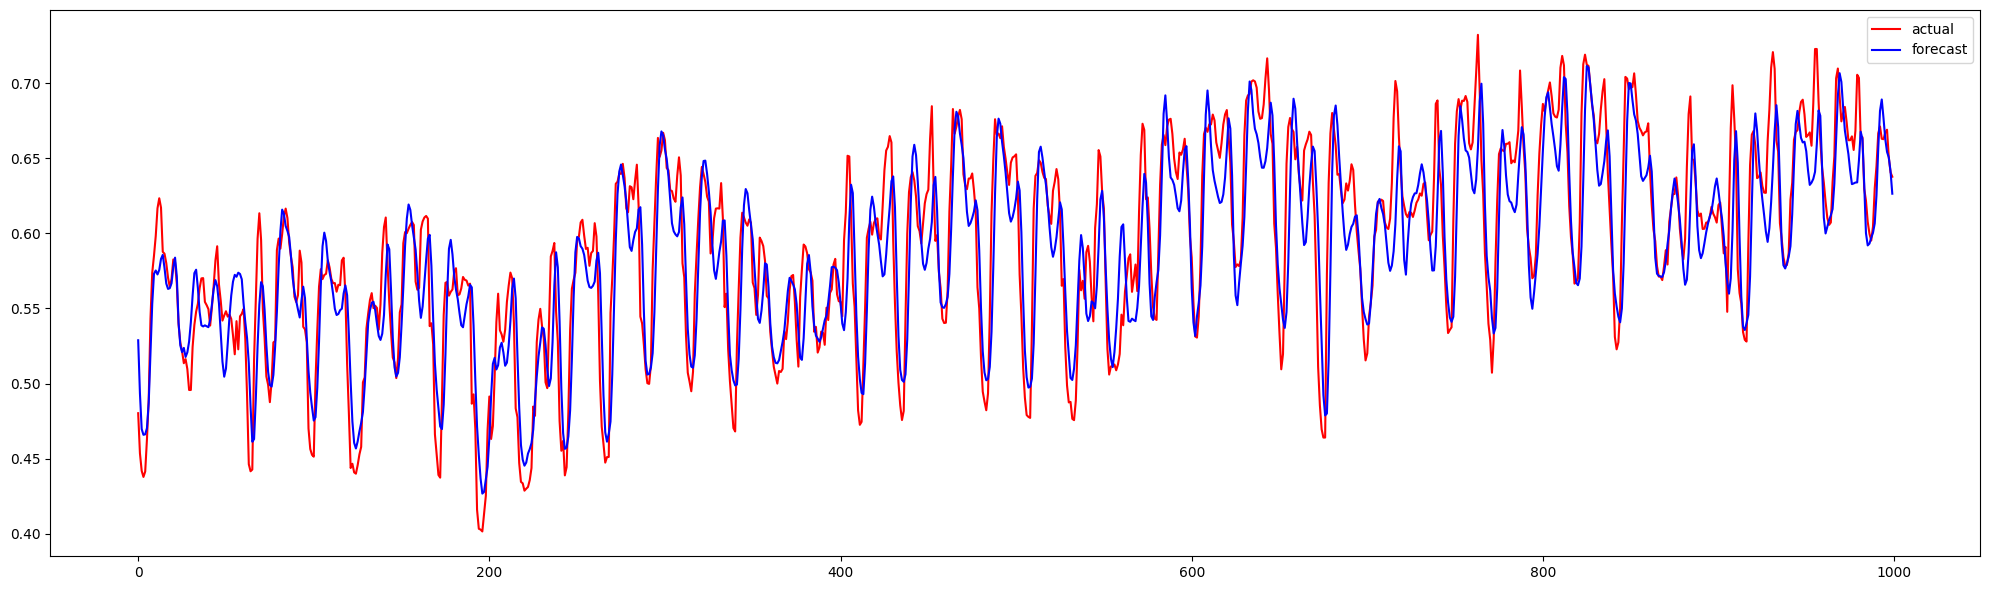

In [53]:
output_cols=['total load actual scaled', 'price actual scaled']
series = valid_s.drop(output_cols, axis=1).copy()
forecast = model_forecast(single_step_single_output_price_model, series, window_size, batch_size)

actual = valid_s.iloc[window_size:]['price actual scaled'].to_list()

actual = valid_s.iloc[window_size:]['price actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='actual')
ax.plot(forecast[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Load
output_cols = ['total load actual scaled']
train_load_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)





In [ ]:
lr_history = adjust_learning_rate(train_load_set)

(0.0001, 1.0, 0.0, 0.1)

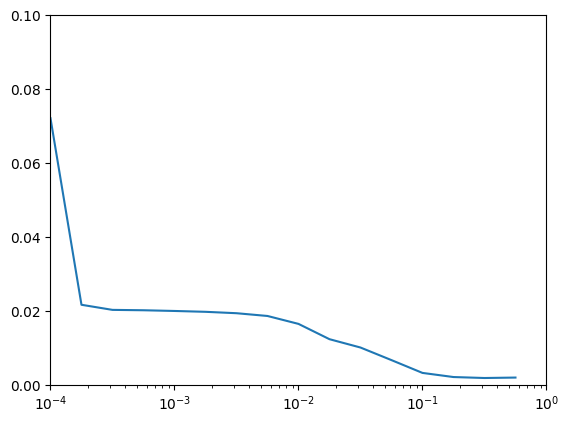

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 0.1])

In [ ]:
single_step_single_output_load_model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

validation_load_set = windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

history = single_step_single_output_load_model.fit(train_load_set, validation_data=validation_load_set, epochs=30, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    436/Unknown 27s 48ms/step - loss: 0.0242 - mae: 0.1834

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.0242 - mae: 0.1833 - val_loss: 0.0123 - val_mae: 0.1320
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - loss: 0.0095 - mae: 0.1095 - val_loss: 0.0029 - val_mae: 0.0580
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - loss: 0.0041 - mae: 0.0686 - val_loss: 0.0022 - val_mae: 0.0506
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.0031 - mae: 0.0595 - val_loss: 0.0018 - val_mae: 0.0458
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 0.0025 - mae: 0.0539 - val_loss: 0.0022 - val_mae: 0.0528
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0023 - mae: 0.0509 - val_loss: 0.0013 - val_mae: 0.0387
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - loss: 0.0018 - mae: 0.0450 - val_loss: 0.0011 - val_mae: 0.0342
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0016 - mae: 0.0431 - val_loss: 0.0010 - val_mae: 0.0346
Epoch 9/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/st

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


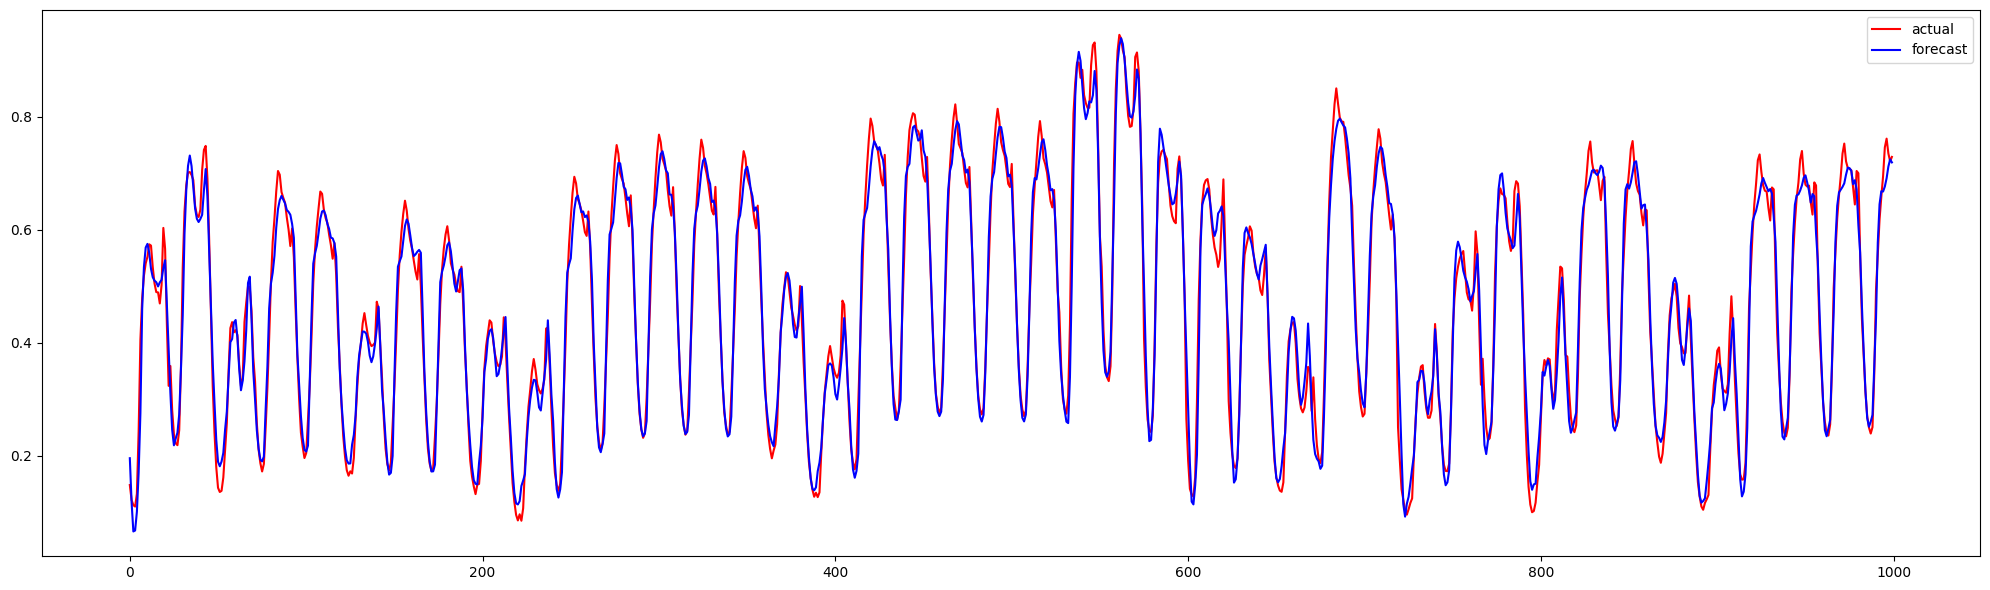

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']
series = valid_s.drop(output_cols, axis=1).copy()
forecast = model_forecast(single_step_single_output_load_model, series, window_size, batch_size)

actual = valid_s.iloc[window_size:]['total load actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='actual')
ax.plot(forecast[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(actual, forecast[:-1])
mae = mean_absolute_error(actual, forecast[:-1])

print(f'mse: {mse}')
print(f'mae: {mae}')

mse: 0.0012849943852886374
mae: 0.026811771973567454


price

In [ ]:
# Price

column_names = train_s.columns.to_list()
input_cols = ['total load actual_roll_scaled', 'price actual_roll_scaled']
output_cols = ['price actual scaled']
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 10000 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data


train_price_set = windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

In [ ]:
lr_history = adjust_learning_rate(train_price_set)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - loss: 0.0821 - mae: 0.3806 - learning_rate: 1.0000e-04
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - loss: 0.0129 - mae: 0.1279 - learning_rate: 2.1544e-04
Epoch 3/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0061 - mae: 0.0803 - learning_rate: 4.6416e-04
Epoch 4/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0061 - mae: 0.0807 - learning_rate: 0.0010
Epoch 5/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.0059 - mae: 0.0792 - learning_rate: 0.0022
Epoch 6/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0053 - mae: 0.0760 - learning_rate: 0.0046
Epoch 7/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0040 - mae: 0.0671 - learning_rate: 0.0100
Epoch 8/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - loss: 0.0033 - mae: 0.0625 - learning_rate: 0.0215
Epoch 9/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.0035 - mae: 0.0641 - learning_rate: 0.0464
Epoch 10/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.0036 - mae: 0.0651 - learning_rate: 0.1000
Epoch 11/15
437/437 ━━━━━━━━━━━━━━━━━━━

(0.0001, 10.0, 0.0, 0.05)

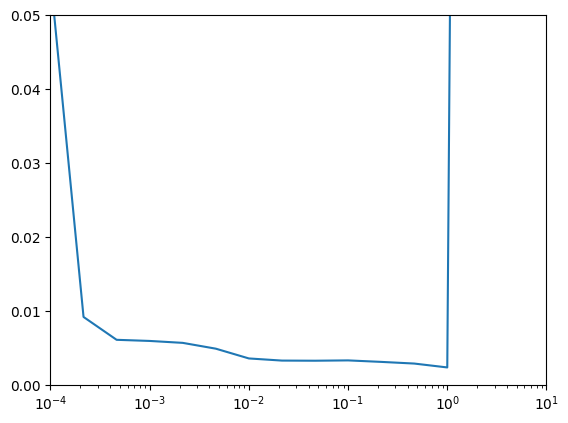

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 0.05])

In [ ]:
single_step_single_output_price_model = create_model(initial_lr=5e-3)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

validation_price_set = windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

history = single_step_single_output_price_model.fit(train_price_set, validation_data=validation_price_set, epochs=40, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
    437/Unknown 37s 61ms/step - loss: 0.0160 - mae: 0.1208

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - loss: 0.0159 - mae: 0.1208 - val_loss: 0.0060 - val_mae: 0.0960
Epoch 2/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - loss: 0.0045 - mae: 0.0705 - val_loss: 0.0035 - val_mae: 0.0720
Epoch 3/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - loss: 0.0036 - mae: 0.0646 - val_loss: 0.0027 - val_mae: 0.0619
Epoch 4/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - loss: 0.0033 - mae: 0.0620 - val_loss: 0.0026 - val_mae: 0.0607
Epoch 5/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 0.0033 - mae: 0.0623 - val_loss: 0.0025 - val_mae: 0.0577
Epoch 6/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0033 - mae: 0.0613 - val_loss: 0.0025 - val_mae: 0.0584
Epoch 7/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - loss: 0.0033 - mae: 0.0616 - val_loss: 0.0024 - val_mae: 0.0551
Epoch 8/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - loss: 0.0032 - mae: 0.0612 - val_loss: 0.0024 - val_mae: 0.0562
Epoch 9/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/st

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']
series = valid_s.drop(output_cols, axis=1).copy()
forecast = model_forecast(single_step_single_output_price_model, series, window_size, batch_size)

actual = valid_s.iloc[window_size:]['price actual scaled'].to_list()

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


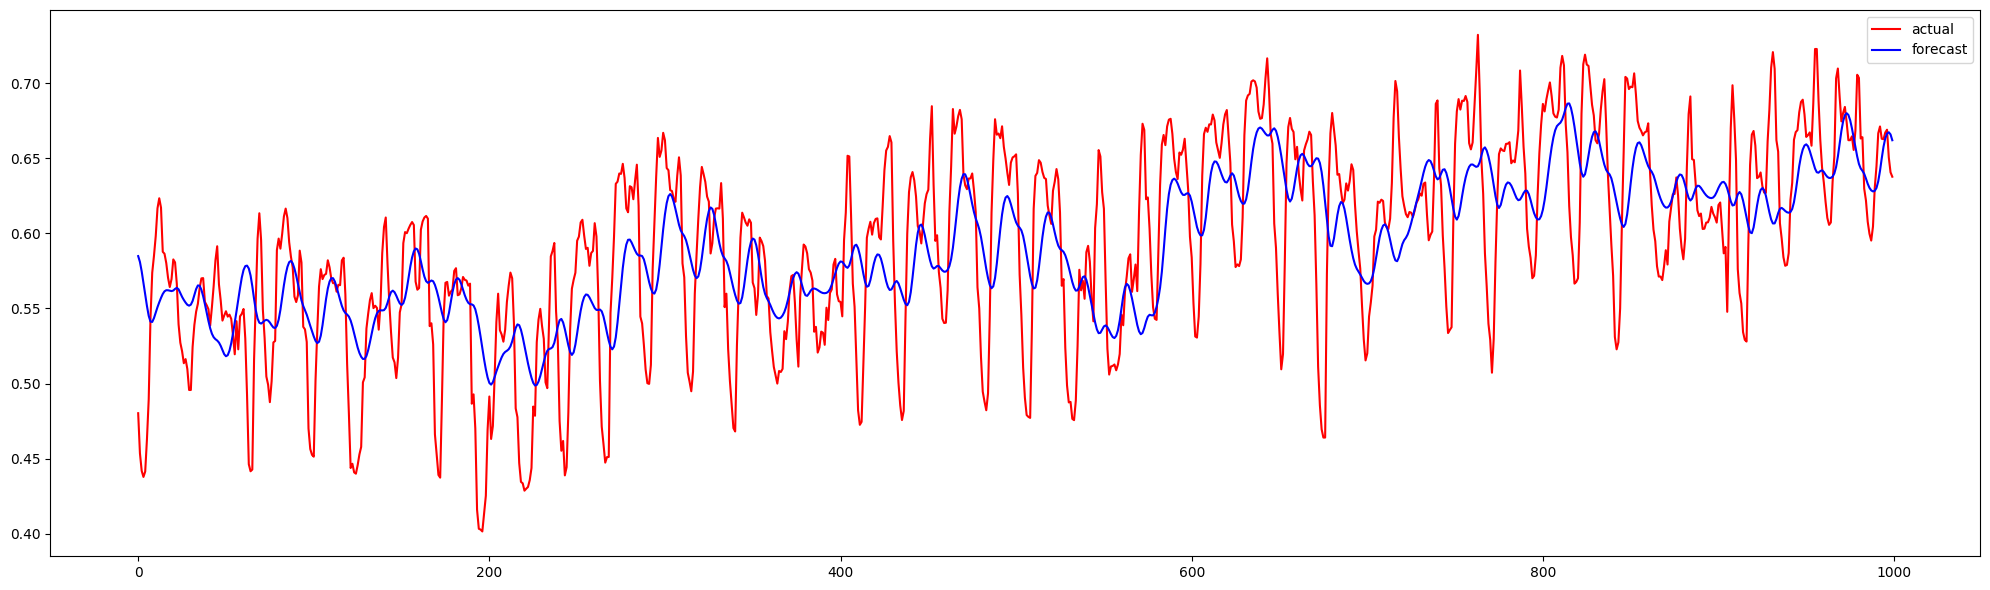

In [ ]:
actual = valid_s.iloc[window_size:]['price actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='actual')
ax.plot(forecast[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mse = mean_squared_error(actual, forecast[:-1])
mae = mean_absolute_error(actual, forecast[:-1])

print(f'mse: {mse}')
print(f'mae: {mae}')

mse: 0.003763701154510826
mae: 0.04711412845520199


Forecast

In [ ]:
valid_s.columns

Index(['total load actual_roll_scaled', 'price actual_roll_scaled',
       'total load actual scaled', 'price actual scaled'],
      dtype='object')

In [ ]:
# Forecast
forecast_size=24

last_rows = train_s[100:124].copy()

input_columns = ['total load actual_roll_scaled', 'price actual_roll_scaled']
last_data = last_rows[input_columns].values

# Reshape last_data to match the model's expected input shape (batch_size, time_steps, features)
input_data = last_data.reshape(1, window_size, len(input_columns))


# Initialize buffers to store the last two predicted values for rolling calculations
rolling_window = 3
roll_load_buffer = list(last_rows['total load actual scaled'].values[-rolling_window+1:])

# Initialize an empty list to store the predictions
predictions = []


# Recursively predict the next 24 hours
for _ in range(forecast_size):
    # Predict the next time step
    next_load = single_step_single_output_model.predict(input_data)
    next_price = single_step_single_output_price_model.predict(input_data)

    # Store the prediction
    predictions.append((next_load[0][0], next_price[0][0]))

    # Update the buffers with the new prediction (simulating the new actual values)
    roll_load_buffer.append(next_load[0][0])
    roll_price_buffer.append(next_price[0][0])

    # Keep only the last three values in the buffer
    if len(roll_load_buffer) > 3:
        roll_load_buffer.pop(0)
    if len(roll_price_buffer) > 3:
        roll_price_buffer.pop(0)

    # Calculate the new rolling scaled values
    total_load_roll_scaled = np.mean(roll_load_buffer)
    price_roll_scaled = np.mean(roll_price_buffer)

    # Update the input data with the new rolling scaled values
    next_input = np.array([[total_load_roll_scaled, price_roll_scaled]])
    input_data = np.append(input_data[:, 1:, :], [next_input], axis=1)

# Convert predictions to a NumPy array for easier manipulation
predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [ ]:
predictions.shape

(24, 2)

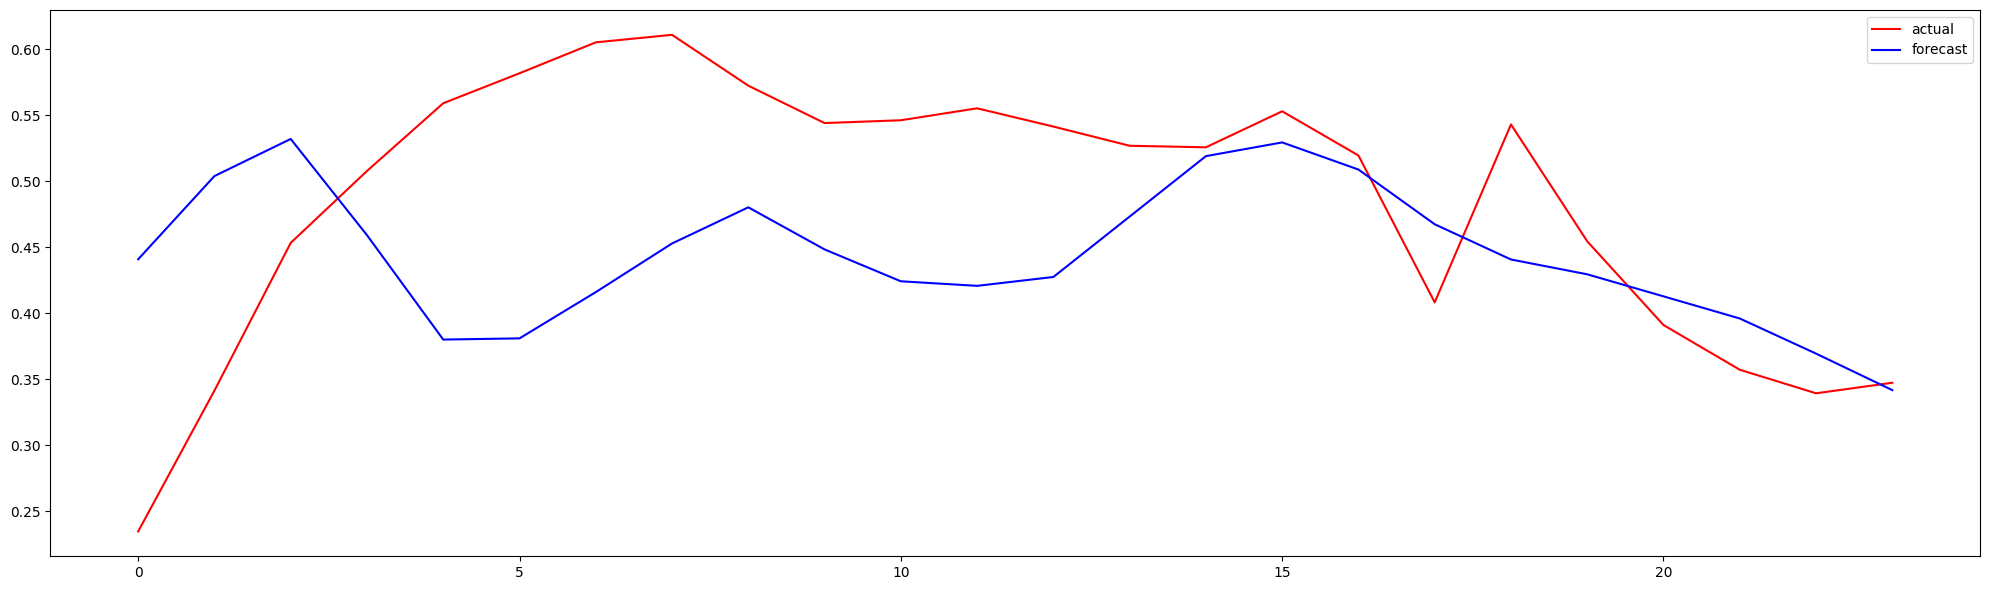

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']

actual = train_s.iloc[124:148]['total load actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(predictions[:,0], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

Single Step Multi-Output

In [ ]:
column_names = train_s.columns.to_list()
input_cols = ['total load actual_roll_scaled', 'price actual_roll_scaled']
output_cols = ['total load actual scaled', 'price actual scaled']
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 10000 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

train_set = windowed_dataset(train_s, window_size, batch_size, shuffle_buffer_size, input_columns=input_cols, output_columns=output_cols, column_names=column_names)

```
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 48, 2)
shape of second element: (32, 2)
```

In [ ]:
# Build CNN-LSTM-DNN Model
def create_uncompiled_model():
# Build CNN-LSTM-DNN Model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(2),
    ])
    return model

def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 2))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=10, callbacks=[lr_schedule])

    return history



In [ ]:
lr_history = adjust_learning_rate(train_set)

(1e-05, 1.0, 0.0, 0.1)

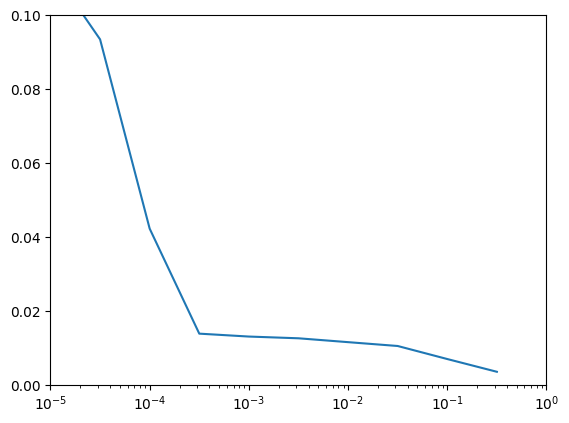

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-5, 1, 0, 0.1])

In [ ]:
def create_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=400,
        decay_rate=0.9,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model


single_step_single_output_model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

validation_load_set = windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

history = single_step_single_output_model.fit(train_set, validation_data=validation_load_set, epochs=30, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
    436/Unknown 35s 64ms/step - loss: 0.0195 - mae: 0.1511

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - loss: 0.0194 - mae: 0.1510 - val_loss: 0.0130 - val_mae: 0.1415
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - loss: 0.0090 - mae: 0.1025 - val_loss: 0.0038 - val_mae: 0.0674
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - loss: 0.0050 - mae: 0.0768 - val_loss: 0.0030 - val_mae: 0.0623
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - loss: 0.0040 - mae: 0.0687 - val_loss: 0.0030 - val_mae: 0.0595
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - loss: 0.0034 - mae: 0.0619 - val_loss: 0.0022 - val_mae: 0.0511
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - loss: 0.0029 - mae: 0.0569 - val_loss: 0.0019 - val_mae: 0.0483
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 0.0024 - mae: 0.0515 - val_loss: 0.0017 - val_mae: 0.0448
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - loss: 0.0021 - mae: 0.0484 - val_loss: 0.0020 - val_mae: 0.0497
Epoch 9/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/st

In [ ]:
def model_forecast(model, series, feature_columns, window_size, batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      feature_columns (list of str or int) - the names or indices of the columns to be used as features
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      Forecast
    """


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series[feature_columns])

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast


In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']
series = valid_s.drop(output_cols, axis=1).copy()

forecast = model_forecast(model=single_step_single_output_model, series=series, feature_columns=input_cols, window_size=window_size, batch_size=batch_size)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
forecast[:10]

array([[0.12892112, 0.4787047 ],
       [0.03054553, 0.43123743],
       [0.02024005, 0.4171409 ],
       [0.08237681, 0.4351732 ],
       [0.14821993, 0.4616752 ],
       [0.18161237, 0.492961  ],
       [0.2555672 , 0.528764  ],
       [0.40640217, 0.55701643],
       [0.5431843 , 0.5707669 ],
       [0.58890337, 0.5689811 ]], dtype=float32)

In [ ]:
valid_s.columns

Index(['total load actual_roll_scaled', 'price actual_roll_scaled',
       'total load actual scaled', 'price actual scaled'],
      dtype='object')

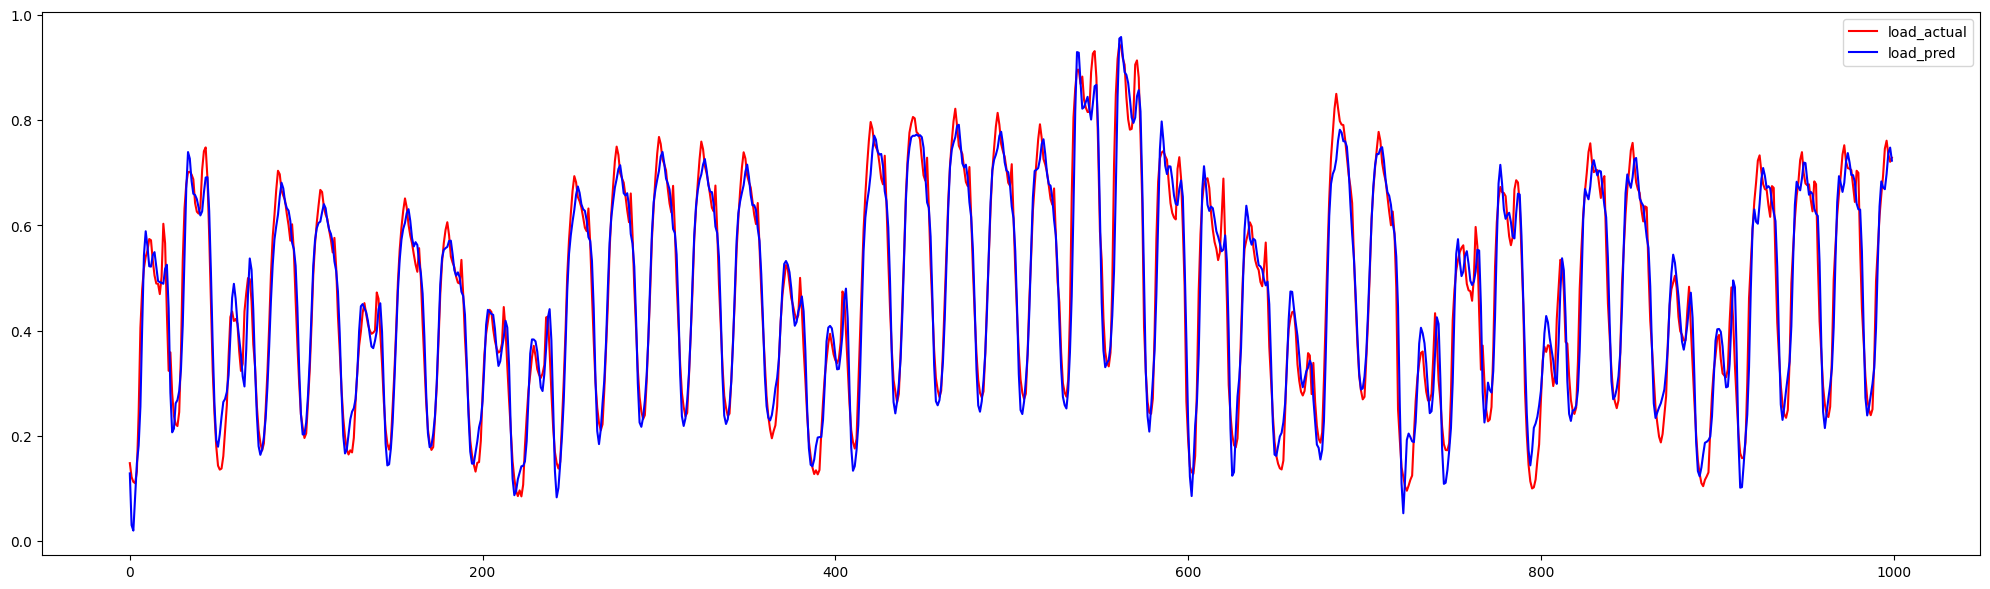

In [ ]:
price_pred = forecast[:-1,0]
actual = valid_s['total load actual scaled'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

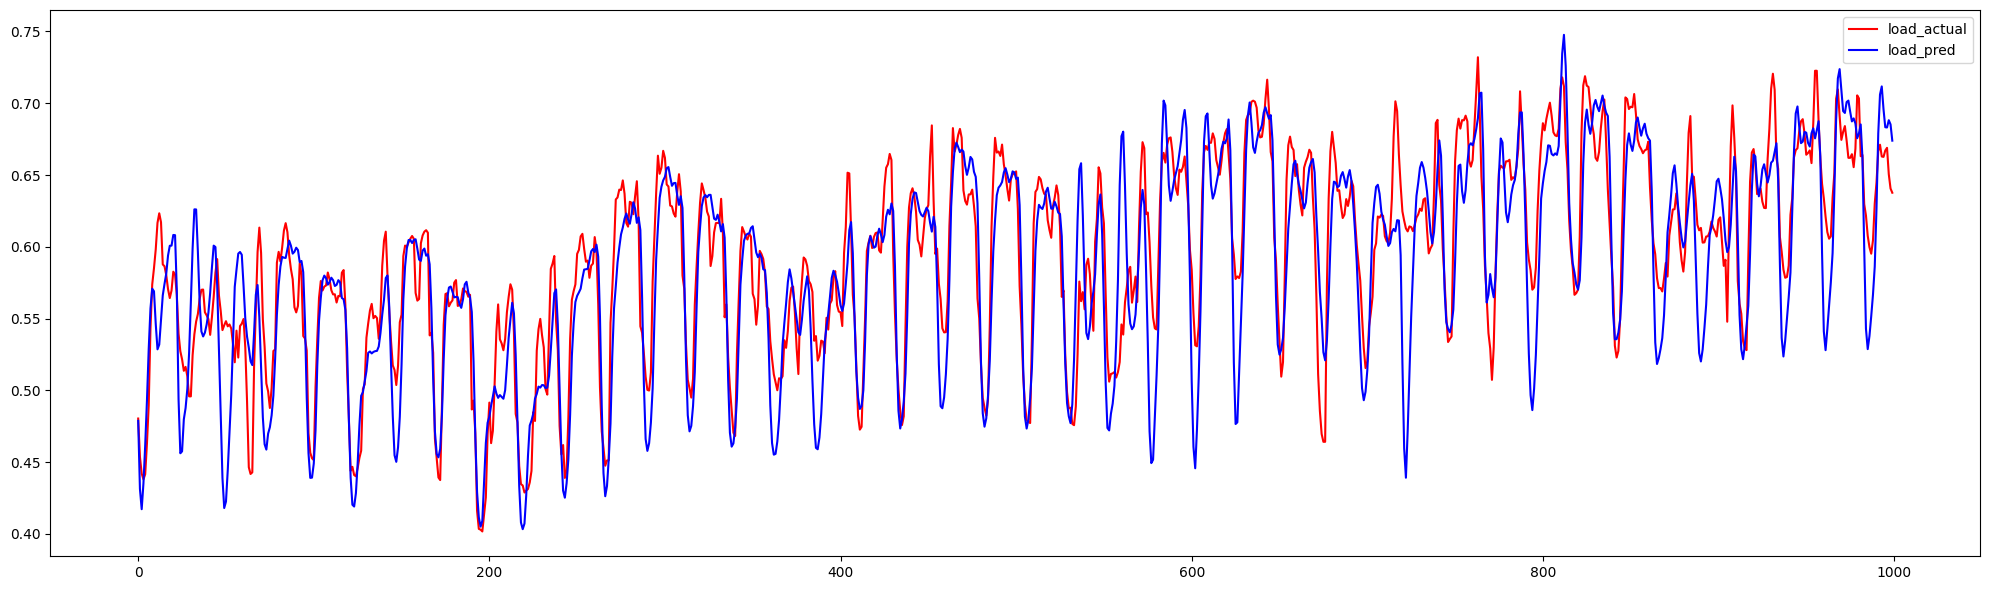

In [ ]:
price_pred = forecast[:-1,1]
actual = valid_s['price actual scaled'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
actual = valid_s['total load actual scaled'][window_size:].to_list()
mse_load = mean_squared_error(actual, forecast[:-1,0])
mae_load = mean_absolute_error(actual, forecast[:-1,0])

print(f'mse: {mse_load}')
print(f'mae: {mae_load}')

mse: 0.002500065600575233
mae: 0.03884282211337185


In [ ]:
actual = valid_s['price actual scaled'][window_size:].to_list()
mse_price = mean_squared_error(actual, forecast[:-1,1])
mae_price = mean_absolute_error(actual, forecast[:-1,1])

print(f'mse: {mse_price}')
print(f'mae: {mae_price}')

mse: 0.0019220041427847267
mae: 0.03316813190579874


In [ ]:
# Forecast
forecast_size=24

last_rows = valid_s[:48].copy()

input_columns = ['total load actual_roll_scaled', 'price actual_roll_scaled']
last_data = last_rows[input_columns].values

# Reshape last_data to match the model's expected input shape (batch_size, time_steps, features)
input_data = last_data.reshape(1, window_size, len(input_columns))


# Initialize buffers to store the last two predicted values for rolling calculations
rolling_window = 3
roll_load_buffer = list(last_rows['total load actual scaled'].values[-rolling_window+1:])
roll_price_buffer = list(last_rows['price actual scaled'].values[-rolling_window+1:])

# Initialize an empty list to store the predictions
predictions = []


# Recursively predict the next 24 hours
for _ in range(forecast_size):
    # Predict the next time step
    next_values = single_step_single_output_model.predict(input_data)

    # Store the prediction
    predictions.append((next_values[0][0], next_values[0][1]))

    # Update the buffers with the new prediction (simulating the new actual values)
    roll_load_buffer.append(next_values[0][0])
    roll_price_buffer.append(next_values[0][1])

    # Keep only the last three values in the buffer
    if len(roll_load_buffer) > 3:
        roll_load_buffer.pop(0)
    if len(roll_price_buffer) > 3:
        roll_price_buffer.pop(0)

    # Calculate the new rolling scaled values
    total_load_roll_scaled = np.mean(roll_load_buffer)
    price_roll_scaled = np.mean(roll_price_buffer)

    # Update the input data with the new rolling scaled values
    next_input = np.array([[total_load_roll_scaled, price_roll_scaled]])
    input_data = np.append(input_data[:, 1:, :], [next_input], axis=1)

# Convert predictions to a NumPy array for easier manipulation
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


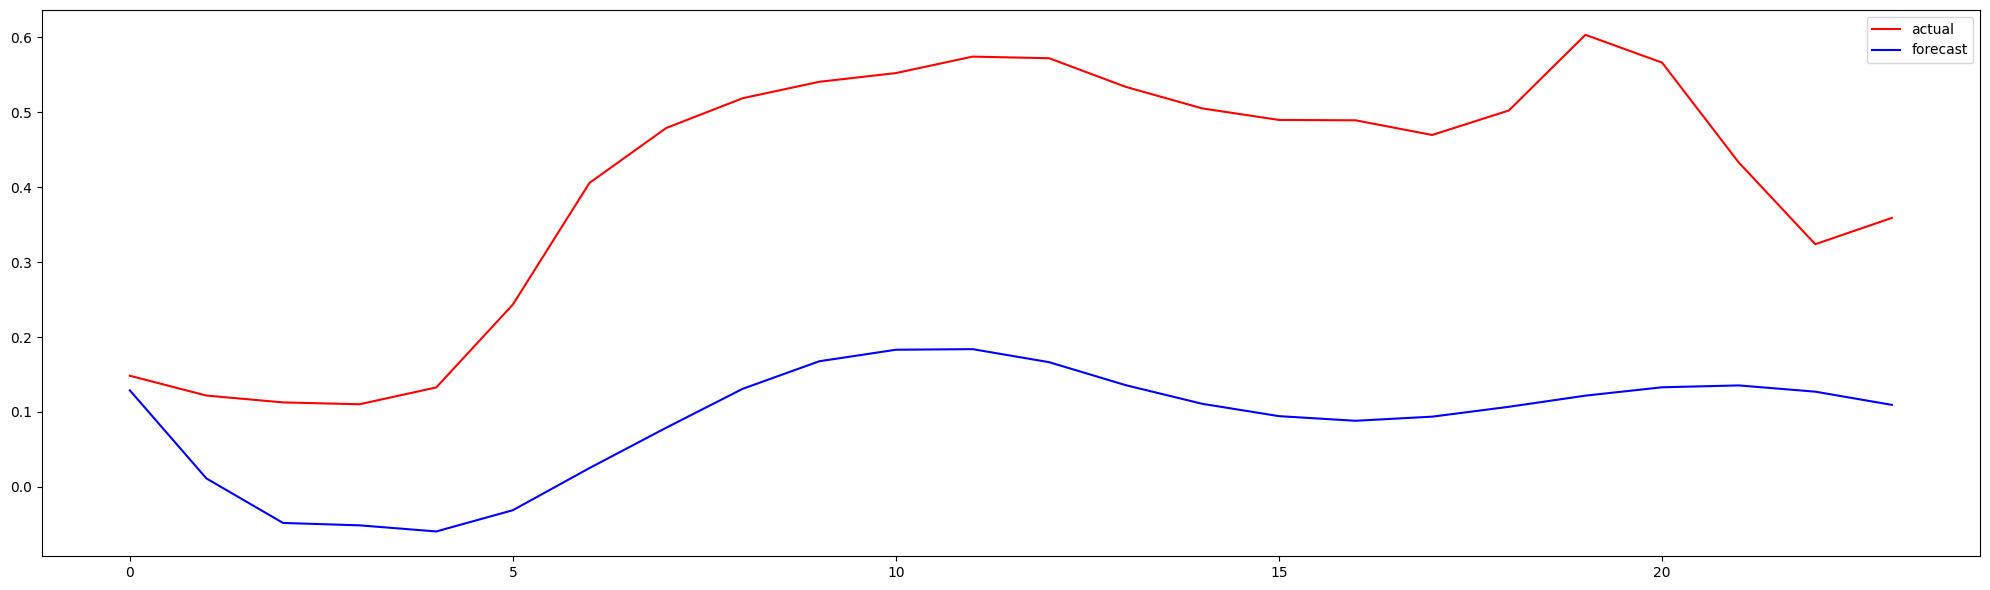

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']

actual = valid_s.iloc[48:72]['total load actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(predictions[:,0], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()


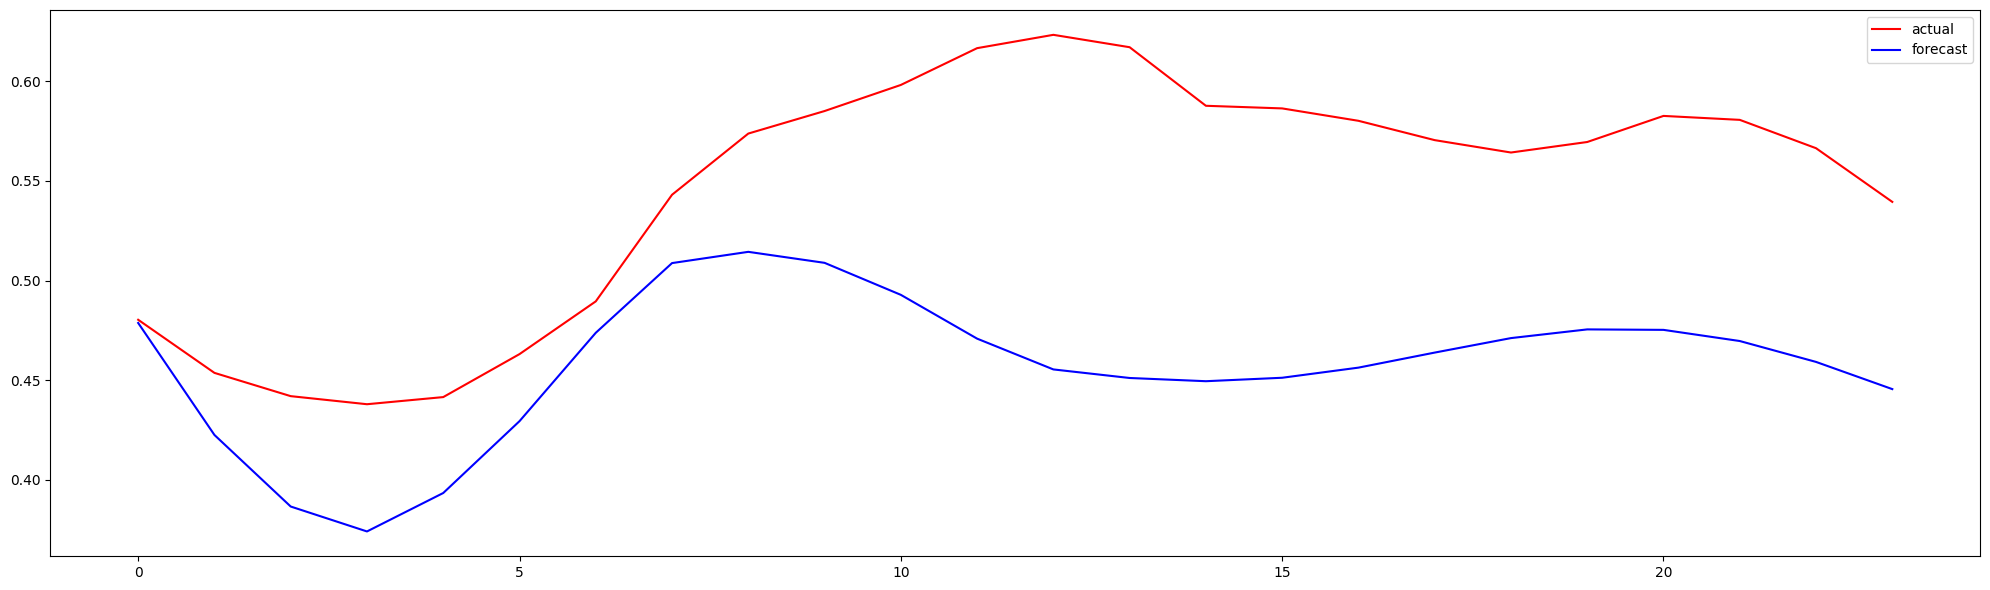

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']

actual = valid_s.iloc[48:72]['price actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(predictions[:,1], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
zz = single_step_single_output_model.predict(input_data)
zz.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 2)

##### Multi_step

###### Single Shot (multi-output)

the entire time sereis is predicted at once

This is the most general case, all other cases are just special case of this situation

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1)))

    if shuffle_buffer_size is not None:
        # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset



In [ ]:
input_cols = ['total load actual_roll_scaled', 'price actual_roll_scaled']
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

train_s = train[input_cols + output_cols].copy()
valid_s = valid[input_cols + output_cols].copy()
test_s = test[input_cols + output_cols].copy()

# Parameters
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 10000 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data
forecast_size = 24


train_set = windowed_dataset(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)

In [ ]:
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 48, 2)
shape of second element: (32, 24, 2)


## 3. Model Training

### CNN-LSTM-DNN

In [ ]:
# Build CNN-LSTM-DNN Model

def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Lambda(lambda x: x[:,-forecast_size:,:])
    ])

    return model

def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=80, callbacks=[lr_schedule])

    return history


In [ ]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - loss: 0.0752 - mae: 0.3360 - learning_rate: 1.0000e-04
Epoch 2/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 85s 55ms/step - loss: 0.0163 - mae: 0.1447 - learning_rate: 1.1220e-04
Epoch 3/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - loss: 0.0145 - mae: 0.1385 - learning_rate: 1.2589e-04
Epoch 4/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - loss: 0.0144 - mae: 0.1379 - learning_rate: 1.4125e-04
Epoch 5/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - loss: 0.0144 - mae: 0.1375 - learning_rate: 1.5849e-04
Epoch 6/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - loss: 0.0142 - mae: 0.1369 - learning_rate: 1.7783e-04
Epoch 7/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - loss: 0.0142 - mae: 0.1363 - learning_rate: 1.9953e-04
Epoch 8/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - loss: 0.0141 - mae: 0.1360 - learning_rate: 2.2387e-04
Epoch 9/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 0.0140 - mae: 0.1354 - learning_rate: 2.5119e-04
E

(0.0001, 1.0, 0.0, 0.08)

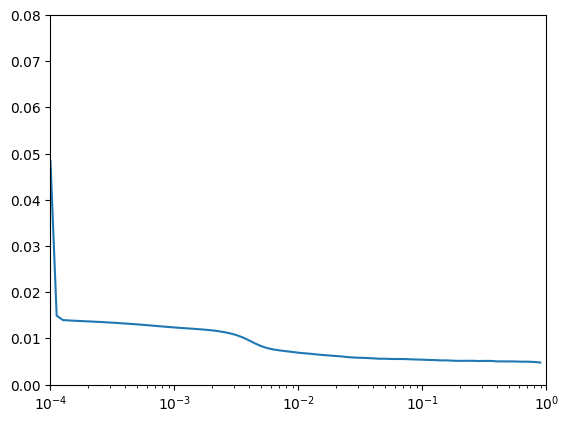

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 1, 0, 0.08])

In [ ]:
valid_set = windowed_dataset(series = valid_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

In [ ]:
def create_model():
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=4e-1, momentum=0.9),
                  metrics=["mae"])
    return model

model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 68s 69ms/step - loss: 0.0160 - mae: 0.1405 - val_loss: 0.0066 - val_mae: 0.0850
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 56s 61ms/step - loss: 0.0066 - mae: 0.0877 - val_loss: 0.0057 - val_mae: 0.0791
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 60s 65ms/step - loss: 0.0060 - mae: 0.0825 - val_loss: 0.0052 - val_mae: 0.0734
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - loss: 0.0057 - mae: 0.0802 - val_loss: 0.0053 - val_mae: 0.0744
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 113s 94ms/step - loss: 0.0056 - mae: 0.0792 - val_loss: 0.0047 - val_mae: 0.0694
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 93s 96ms/step - loss: 0.0055 - mae: 0.0781 - val_loss: 0.0055 - val_mae: 0.0747
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - loss: 0.0054 - mae: 0.0778 - val_loss: 0.0047 - val_mae: 0.0689
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - loss: 0.0053 - mae: 0.0763 - val_loss: 0.0051 - val_mae: 0.0724
Epoch 9/30
875/875 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
prediction = model.predict(test_input)

test_set = windowed_dataset( series = test_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)
test_input = test_set.map(lambda x, y: x)
test_y = test_set.map(lambda x, y: y)

test_output = []
for outputs in test_y:
    test_output.append(outputs.numpy())
test_output = np.concatenate(test_output, axis=0)

### XGBoost

In [ ]:
df.head()

,total load actual,price actual,total load actual_roll,price actual_roll
time,,,,
2015-01-01 01:00:00,22734.0,64.48,24167.000000,64.936667
2015-01-01 02:00:00,21286.0,59.32,22800.666667,62.906667
2015-01-01 03:00:00,20264.0,56.04,21428.000000,59.946667
2015-01-01 04:00:00,19905.0,53.63,20485.000000,56.330000
2015-01-01 05:00:00,20010.0,51.73,20059.666667,53.800000


In [ ]:
import holidays


def create_features(mother_dataset):
    """
    Create time series features from the datetime index and existing variables
    """
    df = mother_dataset.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    # Use Spain holidays
    spain_holidays = holidays.Spain()
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in spain_holidays else 0)

    for lag in range(1, 25):
        df[f'load_lag_{lag}'] = df['total load actual'].shift(lag)
        df[f'price_lag_{lag}'] = df['price actual'].shift(lag)
    # Dropping NaN values resulting from rolling operation
    df.dropna(inplace=True)

    return df



In [ ]:
df = df.drop(['total load actual_roll','price actual_roll'], axis=1)
ds = create_features(df)
ds.head()

,total load actual,price actual,hour,dayofweek,quarter,month,dayofmonth,dayofyear,is_month_start,is_month_end,...,load_lag_20,price_lag_20,load_lag_21,price_lag_21,load_lag_22,price_lag_22,load_lag_23,price_lag_23,load_lag_24,price_lag_24
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 01:00:00,23214.0,54.70,1,4,1,1,2,2,0,0,...,20010.0,51.73,19905.0,53.63,20264.0,56.04,21286.0,59.32,22734.0,64.48
2015-01-02 02:00:00,22540.0,54.91,2,4,1,1,2,2,0,0,...,20377.0,51.43,20010.0,51.73,19905.0,53.63,20264.0,56.04,21286.0,59.32
2015-01-02 03:00:00,22096.0,53.07,3,4,1,1,2,2,0,0,...,20094.0,48.98,20377.0,51.43,20010.0,51.73,19905.0,53.63,20264.0,56.04
2015-01-02 04:00:00,22066.0,54.23,4,4,1,1,2,2,0,0,...,20637.0,54.20,20094.0,48.98,20377.0,51.43,20010.0,51.73,19905.0,53.63
2015-01-02 05:00:00,22275.0,58.22,5,4,1,1,2,2,0,0,...,22250.0,58.94,20637.0,54.20,20094.0,48.98,20377.0,51.43,20010.0,51.73


In [ ]:
ds.shape

(35038, 62)

In [ ]:
split_step = int(len(ds)*0.8)
train = ds.iloc[:split_step]
val = ds.iloc[split_step:]

valid = val.iloc[:int(len(val)*0.5)].copy()
test = val.iloc[int(len(val)*0.5):].copy()

In [ ]:
train_x = train.drop(['total load actual', 'price actual'], axis=1)
train_load = train['total load actual']
train_price = train['price actual']

valid_x = valid.drop(['total load actual', 'price actual'], axis=1)
valid_load = valid['total load actual']
valid_price = valid['price actual']

test_x = test.drop(['total load actual', 'price actual'], axis=1)
test_load = test['total load actual']
test_price = test['price actual']

#### Load

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 5, 1),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500, 1000],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))



Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.4, 'reg_alpha': 0.2, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
Lowest RMSE for total load actual:  528.8128928491752


In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': [4],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'n_estimators': [1000, 1300],
    'min_child_weight': [4, 5, 6],
    'gamma': [0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.3, 0.4, 0.5]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters for total load actual:  {'reg_lambda': 0.4, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 1300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
Lowest RMSE for total load actual:  522.3293930256864


In [ ]:
dtrain_load = xgb.DMatrix(train_x, label=train_load)

# Define the parameters for the model
parameters = {'reg_lambda': 0.4,
              'reg_alpha': 0,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 4,
              'learning_rate': 0.1,
              'gamma': 0.2}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=8000,
    nfold=5,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

[0]	train-mae:3544.15476+5.74404	train-rmse:4165.63489+6.89966	test-mae:3544.88094+26.18374	test-rmse:4166.15086+30.11044
[200]	train-mae:325.59645+2.38632	train-rmse:486.01394+3.80907	test-mae:360.93137+6.67634	test-rmse:552.94394+19.18081
[400]	train-mae:272.76455+2.50930	train-rmse:402.79561+4.01961	test-mae:329.58496+4.88251	test-rmse:515.25144+19.10591
[600]	train-mae:241.38144+1.98839	train-rmse:353.15276+2.75154	test-mae:315.27192+4.66231	test-rmse:498.74164+20.27026
[800]	train-mae:216.93299+1.59623	train-rmse:314.18235+2.73018	test-mae:306.18423+4.91483	test-rmse:488.05900+21.46764
[1000]	train-mae:197.95012+1.23532	train-rmse:284.08850+2.06617	test-mae:300.72343+5.14991	test-rmse:481.91095+21.63490
[1200]	train-mae:181.90026+1.07999	train-rmse:259.30731+1.99568	test-mae:296.70520+5.38579	test-rmse:477.63059+21.95347
[1400]	train-mae:168.25056+0.71487	train-rmse:238.47453+1.52109	test-mae:293.74920+5.48055	test-rmse:474.84536+22.54286
[1600]	train-mae:156.27641+0.57839	train-r

In [ ]:
best_num_boost_round = cv_results['test-rmse-mean'].idxmin()
best_num_boost_round

7570

In [ ]:
load_final_model = xgb.train(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=best_num_boost_round
)

In [ ]:
# Prediction
dval_load = xgb.DMatrix(valid_x, label=valid_load)
valid_load_pred = load_final_model.predict(dval_load).reshape(-1, 1)
valid_load = valid_load.values.reshape(-1, 1)

mae = mean_absolute_error(valid_load_pred, valid_load)
print(f"Mean Absolute Error (MAE): {mae}")

# 计算MSE
mse = mean_squared_error(valid_load_pred, valid_load)
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 277.17798520440925
Mean Squared Error (MSE): 216487.78286436378


#### Price

In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 6, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [500, 1000],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for price actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_price)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.2, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
Lowest RMSE for total load actual:  2.6532054769748767


In [ ]:
dtrain_price = xgb.DMatrix(train_x, label=train_price)

# Define the parameters for the model
parameters = {'reg_lambda': 0.2,
              'reg_alpha': 0,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 4,
              'learning_rate': 0.1,
              'gamma': 0.4}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=3000,
    nfold=3,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

[0]	train-mae:9.90742+0.00845	train-rmse:12.93110+0.01781	test-mae:9.90985+0.01869	test-rmse:12.93326+0.03624
[200]	train-mae:1.51106+0.00939	train-rmse:2.07542+0.02224	test-mae:1.71605+0.01794	test-rmse:2.41922+0.04787
[400]	train-mae:1.33097+0.00704	train-rmse:1.80845+0.01635	test-mae:1.66854+0.01774	test-rmse:2.36266+0.04941
[600]	train-mae:1.20447+0.00598	train-rmse:1.62629+0.01416	test-mae:1.65539+0.01624	test-rmse:2.34819+0.04939
[800]	train-mae:1.10261+0.00530	train-rmse:1.48369+0.01255	test-mae:1.65043+0.01504	test-rmse:2.34244+0.04975
[1000]	train-mae:1.01494+0.00448	train-rmse:1.36381+0.00972	test-mae:1.64720+0.01620	test-rmse:2.33923+0.05100
[1180]	train-mae:0.94341+0.00455	train-rmse:1.26648+0.00880	test-mae:1.64678+0.01552	test-rmse:2.33944+0.05109
Best RMSE from cross-validation:  2.3383957042816155
Best MAE from cross-validation:  1.6462252595887026


In [ ]:
best_num_boost_round = cv_results['test-rmse-mean'].idxmin()
best_num_boost_round

1081

In [ ]:
final_price_model = xgb.train(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=best_num_boost_round
)

In [ ]:
valid_price

,price actual
time,
2018-03-14 23:00:00,32.54
2018-03-15 00:00:00,20.14
2018-03-15 01:00:00,14.66
2018-03-15 02:00:00,13.54
2018-03-15 03:00:00,13.77
...,...
2018-08-07 18:00:00,74.22
2018-08-07 19:00:00,75.17
2018-08-07 20:00:00,74.12


In [ ]:
# Prediction
dval_price = xgb.DMatrix(valid_x)
valid_price_pred = final_price_model.predict(dval_price).reshape(-1, 1)
valid_price = valid_price.values.reshape(-1, 1)

mae = mean_absolute_error(valid_price_pred, valid_price)
print(f"Mean Absolute Error (MAE): {mae}")

# 计算MSE
mse = mean_squared_error(valid_price_pred, valid_price)
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 1.5432879746559005
Mean Squared Error (MSE): 4.659157376697544


If the model performs good on the validation set, we move on to predict future values. Firstly, we re-train the full dataset including  training set and validation set

In [ ]:
full_dataset = pd.concat([train, valid])
full_dataset.shape

(31534, 62)

In [ ]:
dfull_train_load = xgb.DMatrix(full_dataset.drop(['total load actual', 'price actual'], axis=1), label=full_dataset['total load actual'])
dfull_train_price = xgb.DMatrix(full_dataset.drop(['total load actual', 'price actual'], axis=1), label=full_dataset['price actual'])

In [ ]:
load_model= xgb.train(
    params=parameters,
    dtrain=dfull_train_load,
    num_boost_round=7570,
)

In [ ]:
price_model= xgb.train(
    params=parameters,
    dtrain=dfull_train_price,
    num_boost_round=1081,
)

,total load actual,price actual,hour,dayofweek,quarter,month,dayofmonth,dayofyear,is_month_start,is_month_end,...,load_lag_20,price_lag_20,load_lag_21,price_lag_21,load_lag_22,price_lag_22,load_lag_23,price_lag_23,load_lag_24,price_lag_24
time,,,,,,,,,,,,,,,,,,,,,
2018-08-07 22:00:00,29365.0,68.97,22,1,3,8,7,219,0,0,...,21767.0,58.7,22237.0,59.21,23102.0,60.13,24361.0,64.44,25967.0,67.17


In [ ]:
history_data = valid[-1:].copy()

new_index = pd.date_range(start=history_data.index[-1], periods=25,
                          freq='H')  # Assuming hourly frequency

extended_data = history_data.reindex(new_index)


def update_features(mother_dataset):
    """
    Create time series features from the datetime index and existing variables
    """
    df = mother_dataset.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    # Use Spain holidays
    spain_holidays = holidays.Spain()
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in spain_holidays else 0)

    return df

extended_data = update_features(extended_data)

In [ ]:
extended_data.iloc[[1]]['hour']

,hour
2018-08-07 23:00:00,23


In [ ]:
window_size = 24

# Iterate through each hour in the extended data
for i in range(1, 25):
    for j in range(1, window_size):
        # Directly assign to the DataFrame using `.iloc`
        extended_data.iloc[i, extended_data.columns.get_loc(f'load_lag_{j+1}')] = extended_data.iloc[i-1, extended_data.columns.get_loc(f'load_lag_{j}')]
        extended_data.iloc[i, extended_data.columns.get_loc(f'price_lag_{j+1}')] = extended_data.iloc[i-1, extended_data.columns.get_loc(f'price_lag_{j}')]
    extended_data.iloc[i, extended_data.columns.get_loc('load_lag_1')] = extended_data.iloc[i-1, extended_data.columns.get_loc('load_lag_1')]
    extended_data.iloc[i, extended_data.columns.get_loc('price_lag_1')] = extended_data.iloc[i-1, extended_data.columns.get_loc('price_lag_1')]

    last_inputs = extended_data.iloc[[i-1]].copy()
    last_inputs = last_inputs.drop(['total load actual', 'price actual'], axis=1)
    dtrain = xgb.DMatrix(last_inputs)
    load = load_model.predict(dtrain)
    price = price_model.predict(dtrain)

    extended_data.iloc[i, extended_data.columns.get_loc('total load actual')] = load[0]
    extended_data.iloc[i, extended_data.columns.get_loc('price actual')] = price[0]

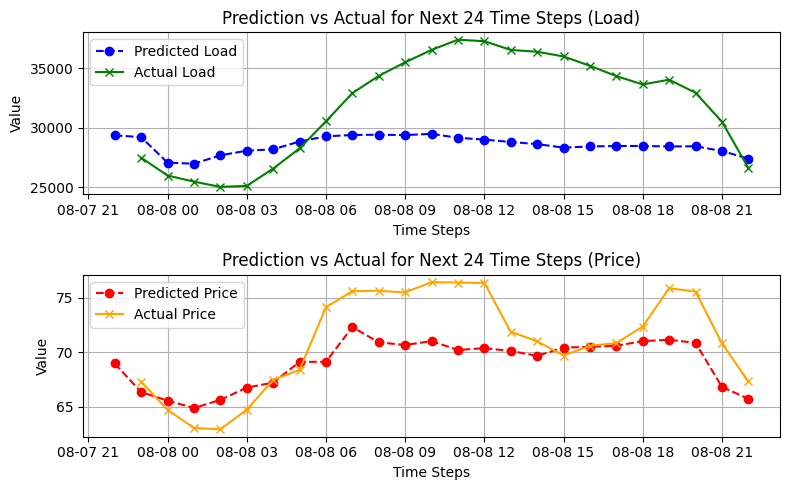

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))

axs[0].plot(extended_data['total load actual'], label='Predicted Load', linestyle='--', marker='o', c='blue')
axs[0].plot(test[:24]['total load actual'], label='Actual Load', linestyle='-', marker='x', c='green')


axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(extended_data['price actual'], label='Predicted Price', linestyle='--', marker='o', c='red')
axs[1].plot(test[:24]['price actual'], label='Actual Price', linestyle='-', marker='x', c= 'orange')
axs[1].set_title(f'Prediction vs Actual for Next 24 Time Steps (Price)')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 4. Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Reshape the predictions and valid outputs to 2D
# This flattens the windows and time steps into a single dimension
prediction_reshaped = prediction.reshape(-1, prediction.shape[-1])  # Shape: (6966*24, 2)
test_output_reshaped = test_output.reshape(-1, test_output.shape[-1])  # Shape: (6966*24, 2)

# Revert the predictions and actual values to their original scales
prediction_reshaped[:, 0] = load_scaler.inverse_transform(prediction_reshaped[:, 0].reshape(-1, 1)).flatten()
prediction_reshaped[:, 1] = price_scaler.inverse_transform(prediction_reshaped[:, 1].reshape(-1, 1)).flatten()

test_output_reshaped[:, 0] = load_scaler.inverse_transform(test_output_reshaped[:, 0].reshape(-1, 1)).flatten()
test_output_reshaped[:, 1] = price_scaler.inverse_transform(test_output_reshaped[:, 1].reshape(-1, 1)).flatten()

# Calculate MSE for each target
mse_load = mean_squared_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mse_price = mean_squared_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Calculate MAE for each target
mae_load = mean_absolute_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mae_price = mean_absolute_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Print the MSE results
print(f'MSE for Load: {mse_load}')
print(f'MSE for Price: {mse_price}')

# Print the MAe results
print(f'MAE for Load: {mae_load}')
print(f'MAE for Price: {mae_price}')

MSE for Load: 7109858.220131684
MSE for Price: 32.32858569674062
MAE for Load: 2032.1090146865224
MAE for Price: 4.537975513299491


## 5. |Deployment and Prediction

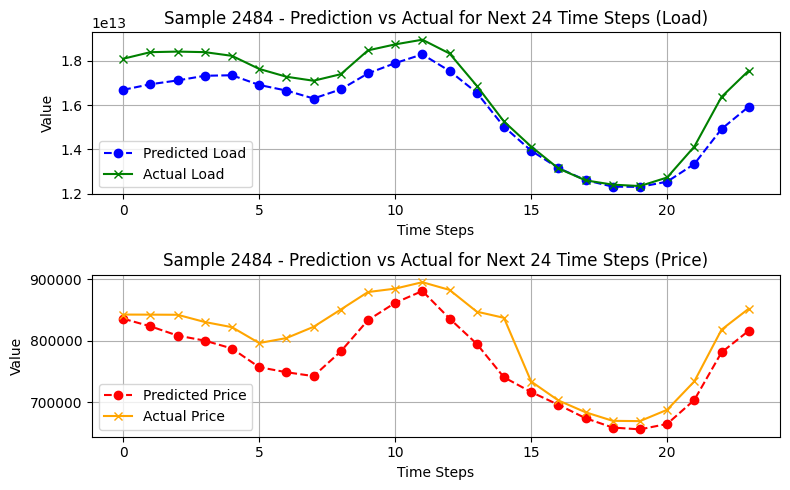

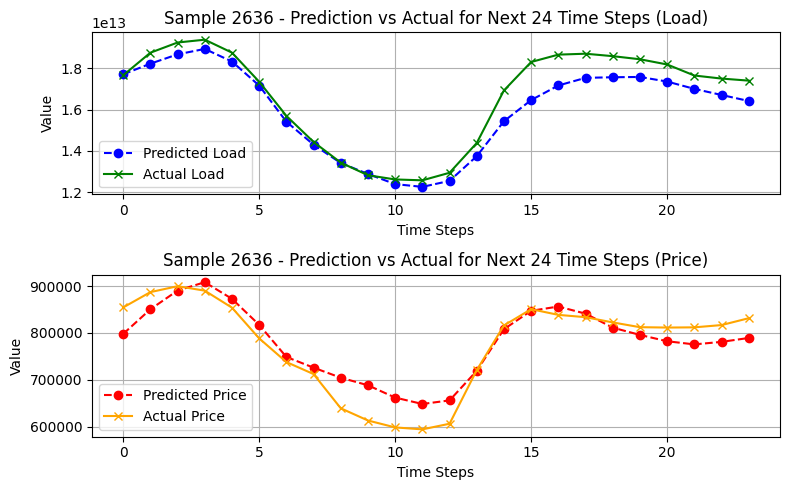

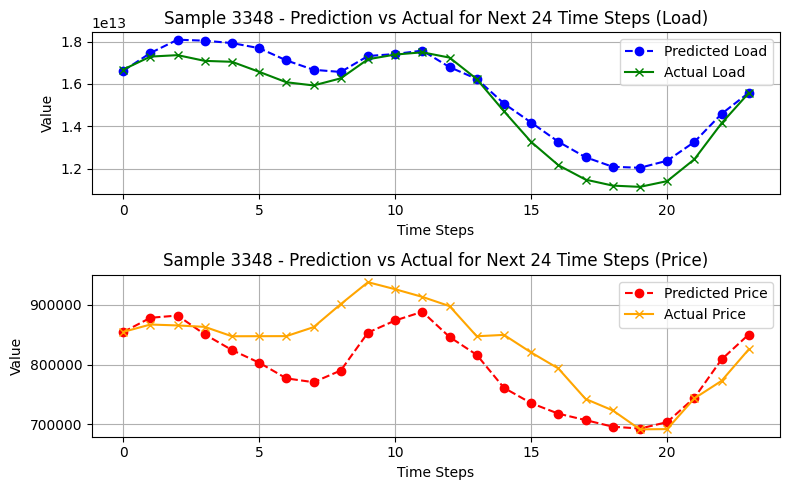

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 3 samples (indices) from the reshaped predictions and valid outputs
num_samples = prediction.shape[0]  # This is 6966 based on your description
random_indices = np.random.choice(num_samples, 3, replace=False)

# Plot predictions vs actual values for the selected samples in original scale
for i, idx in enumerate(random_indices):
    # Revert the predictions and actual values for the selected sample
    original_prediction_load = load_scaler.inverse_transform(prediction[idx, :, 0].reshape(-1, 1)).flatten()
    original_actual_load = load_scaler.inverse_transform(test_output[idx, :, 0].reshape(-1, 1)).flatten()

    original_prediction_price = price_scaler.inverse_transform(prediction[idx, :, 1].reshape(-1, 1)).flatten()
    original_actual_price = price_scaler.inverse_transform(test_output[idx, :, 1].reshape(-1, 1)).flatten()

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    axs[0].plot(original_prediction_load, label='Predicted Load', linestyle='--', marker='o', c='blue')
    axs[0].plot(original_actual_load, label='Actual Load', linestyle='-', marker='x', c='green')
    axs[0].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Load)')
    axs[0].set_xlabel('Time Steps')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(original_prediction_price, label='Predicted Price', linestyle='--', marker='o', c='red')
    axs[1].plot(original_actual_price, label='Actual Price', linestyle='-', marker='x', c= 'orange')
    axs[1].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Price)')
    axs[1].set_xlabel('Time Steps')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

